# 第7章 区分鸟和飞机
- 构建前馈神经网络
- 使用Dataset和DataLoader加载数据
- 了解分类损失
## 7.1 微小图像数据集
图像识别最基本的数据集之一是手写数字识别数据集——MNIST。在这里，我们将使用另一个与之类似的、简单但有趣的数据集，他被称为CIFAR-10.它和它的兄弟数据集CIFAR-100一样，10年来一直是计算机视觉领域的经典之作。

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

### 7.1.1 下载CIFAR-10
让我们导入TorchVision模块并使用datasets模块下载CIFAR-10数据。

我们提供给CIFAR10()函数的第1个参数是数据的下载位置；第2个参数指定我们对训练集还是验证集感兴趣；第三个参数表示如果在第1个参数指定的位置找不到数据，我们是否允许PyTorch下载数据。

In [3]:
from torchvision import datasets
data_path = 'data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # 实例化一个数据集用于训练，如果数据集不存在，则使用TorchVision下载该数据集
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # 使用train=False，获取一个数据集用于验证数据，并在需要时再次下载该数据集

Files already downloaded and verified
Files already downloaded and verified


CIFAR-10由60000张微小的（32像素×32像素）RGB图像组成，用一个整数对应10个级别中的1个：飞机（0）、汽车（1）、鸟（2）、猫（3）、鹿（4）、狗（5）、青蛙（6）、马（7）、船（8）和卡车（9）。

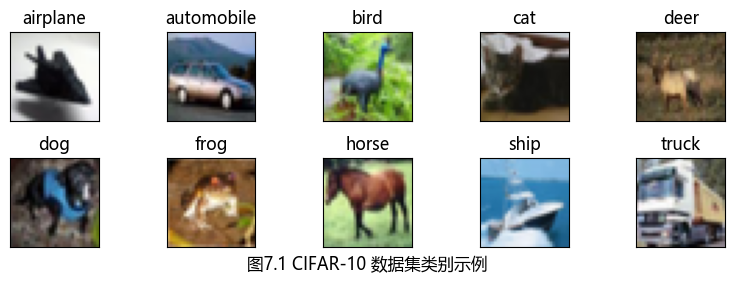

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
fig.suptitle('图7.1 CIFAR-10 数据集类别示例', fontsize=12, y=0.02)
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.tight_layout()  # 调整子图布局，避免重叠
plt.show()

就像 CIFAR-10 一样，数据集子模块为我们提供了对最流行的计算机视觉数据集的预存储访问，如 MNIST、Fashion-MNIST、CIFAR-100、SVHN、COCO 和 Omniglot 等。在每种情况下, 数据集都作为 torch.utils.data.Dataset 的子类返回。我们可以看到，实例 cifar10 的方法解析顺序中包含了它的父类：

In [4]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

### 7.1.2 Dataset类
现在是了解作为 `torch.utils.data.Dataset` 的子类在实践中意味着什么的好时机。查看图7.2，我们可以看到Dataset的全部内容，它是一个需要实现两种函数的对象：`__len__()`和`__getitem__()`，前者返回数据中的项数，后者返回由样本和与之对应的标签（整数索引）组成的项。

![](../img/7_1.png "图7.2 PyTorch Dataset对象的概念：它不一定持有数据，但是它提供了对其进行统一访问的函数__len__()和__getitem__()")

在实践中，当python对象配备了__len__()函数时，我们可以将其作为参数传递给Python的内置函数len()：

In [5]:
len(cifar10)

50000

类似的，由于数据集配备了__getitem__()函数，我们可以使用标准索引对元组和列表进行索引，以访问单个数据项。这里，我们得到一个带有期望输出的PIL（Python Imaging Library，Python图像库）图像，即输出值为整数1，对应图像数据集中的“汽车”:

In [6]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

那么，data.CIFAR10是RGB PIL图像的一个实例，我们马上就可以画出来：

这将产生图7.3所示的输出——一辆红色的汽车！

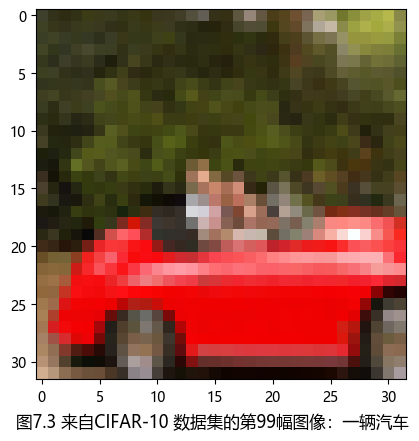

In [8]:
plt.imshow(img)
# 在图像底端添加标题
plt.figtext(0.5, 0.01, "图7.3 来自CIFAR-10 数据集的第99幅图像：一辆汽车", ha='center', fontsize=12)

plt.show()

### 7.1.3 Dataset 变换
我们需要一种方法来将PIL图像变换为PyTorch张量，然后才能使用它做别的事情，因此引入了`torchvision.transforms`模块。这个模块定义了一组可组合的、类似函数的对象，它可以作为参数传递到`TorchVision`模块的数据集，诸如`datasets.CIFAR10(…)`，在数据加载之后，在`__getitem__()`返回之前对数据进行变换我们可以看到可用对象的列表如下所示：

In [9]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

在这些变换的对象中，我们可以看到ToTensor对象，它将NumPy数组和PIL图像变换为张量。它还将输出张量的尺寸设置为C×H×W（通道、高度、宽度）。我们来试一试ToTensor变换，一旦ToTensor被实例化，就可以像调用函数一样调用它，以PIL图像作为参数，返回一个张量作为输出：

In [10]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

图像已变换为 3×32×32 的张量，即一个有 3 个通道(RGB)的 32×32 的图像。注意，标签没有发生任何变化，它仍然是一个整数。正如我们期望的那样，我们可以将变换直接作为参数传递给`dataset.CIFAR10()`：

In [11]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

此时，访问数据集的元素将返回一个张量，而不是PIL图像：

In [12]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

正如预期的那样,形状的第 1 个维度是通道，而标量类型是 float32:

In [13]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

原始 PIL 图像中的值为 0~255(每个通道 8 位)，而 ToTensor 变换将数据变换为每个通道的 32 位浮点数,将值缩小为 0.0~1.0。让我们来验证一下：

In [14]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

我们来验证一下得到的图像是否相同：

正如我们在图 7.4 中看到的,我们得到了与之前相同的输出。

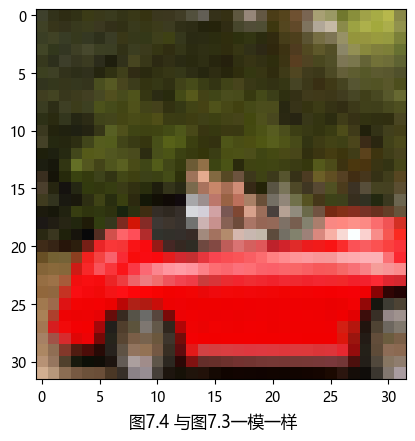

In [15]:
plt.imshow(img_t.permute(1, 2, 0))  # 将轴的顺序由 C×H×W 改为 H×W×C
plt.figtext(0.5, 0.01, "图7.4 与图7.3一模一样", ha='center', fontsize=12)
plt.show()

### 7.1.4 数据归一化
变换非常方便，因为我们可以使用`transforms.Compose()`将它们连接起来，然后在数据集加载器中直接透明地进行数据归一化和数据增强操作。例如，一种好的做法是对数据进行归一化，使每个通道的均值为0，标准差为1。我们在第4章中提到过这一点，但是现在，读完第5章之后，我们有了一个直觉：通过选择在0±1（或2）附近呈线性的激活函数，将数据保持在相同的范围内意味着神经元更有可能具有非零梯度，因此，可以更快地学习。同时，对每个通道进行归一化，使其具有相同的分布，可以保证在相同的学习率下，通过梯度下降实现通道信息的混合和更新。

为了使每个通道的均值为 0、标准差为 1，我们可以应用以下转换来计算数据集中每个通道的平均值和标准差：v_n[c] = (v[c] - mean[c]) /stdev[c]。这正是 `transforms.Normalize()`所做的。 `mean` 和 `stdev` 的值必须离线计算(它们不是通过变换计算的)。现在让我们计算 CIFAR-10 训练 集的平均值和标准差。 

由于 CIFAR-10 数据集很小，我们将完全能够在内存中操作它。让我们将数据集返回的所有张量沿着一个额外的维度进行堆叠：

In [17]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

现在我们可以很容易地计算出每个信道的平均值：

In [18]:
imgs.view(3, -1).mean(dim=1)  
# view(3,−1)保留了3个通道,并将剩余的所有 
# 维度合并为一个维度,从而计算出适当的尺寸大小。
# 这里我们的3×32×32的图像被转换成一个3×1024
# 的向量, 然后对每个通道的1024个元素取平均值

tensor([0.4914, 0.4822, 0.4465])

计算标准差也是类似的：

In [19]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

有了这些数字，我们就可以初始化Normalize变换了：

In [21]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

并将其连接到ToTensor变换：

In [22]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [23]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

注意，此时，从数据集绘制的图像不能为我们提供实际图像的真实表示：

我们得到的重新归一化的红色汽车如图 7.5 所示。这是因为归一化对 RGB 超出 0.0~1.0 的 数据进行了转化，并且调整了通道的总体大小，所有的数据仍然存在，只是 Matplotlib 将其渲染为黑色。我们暂时记住这一点。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9806982..2.126078].


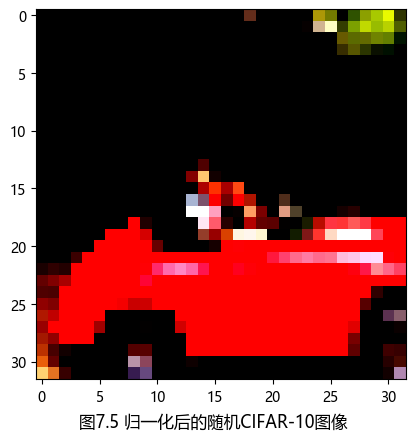

In [24]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.figtext(0.5, 0.01, "图7.5 归一化后的随机CIFAR-10图像", ha='center', fontsize=12)
plt.show()